In [1]:
from sklearn.cluster import KMeans
from helpers import *
from gbd_core.api import GBD
from bitarray import bitarray
import numpy as np

import pickle

from sklearn.decomposition import PCA

features = get_available_features()
#def eval(k, train):
#    data_train = train.copy()
#
#    cluster_assignment = pd.DataFrame(list(zip(data_train['hash'].tolist(), kmeans.labels_)), columns= ["hash", "cluster"])
#
#
#
#    rf = RandomForestClassifier()
#
#    rf.fit(data_train[features], data_train["index"])
#
#    return rf
seed = 0
def clusterbestlist(n_labels=10, k_config=10, seed=0):
    with GBD([ '/home/raphael-zipperer/Uni/BA/database/base.db', '/home/raphael-zipperer/Uni/BA/database/meta.db' ]) as gbd:
        data = gbd.query('(track=main_2023 or track=main_2024) and minisat1m!=yes', resolve=features + ["family"])
    
        df = pd.read_csv("top40.csv")
    
        # Identify families with less than 5 entries
        family_counts = data['family'].value_counts()
        families_to_replace = family_counts[family_counts < 5].index
    
        # Replace the family label with "rest" for these families
        data['family'] = data['family'].apply(lambda x: 'rest' if x in families_to_replace else x)
    
        data_train, data_test = train_test_split(data, test_size=0.2, random_state=seed, stratify=data["family"])
    
        hashes_by_family = data_train.groupby("family")["hash"].apply(list).to_dict()
      
        famindeces = {}
        for fam, hashes in hashes_by_family.items():
            indeces = bestcluster(hashes, k_config).index.tolist()
        
            famindeces[fam] = indeces.copy()
        
        fam_bitarrays = {}
        for fam, indeces in famindeces.items():
            ba = bitarray(40)
            ba.setall(0)
            for index in indeces:
                ba[index] = 1
            fam_bitarrays[fam] = ba
    
        
        bitarrays_list = list(fam_bitarrays.values())
        bitarrays_matrix = np.array([ba.tolist() for ba in bitarrays_list])

        kmeans = KMeans(n_clusters=n_labels, random_state=seed).fit(bitarrays_matrix)
        clusters = kmeans.labels_
    
        # Extract family labels back from the resulting cluster list
        clustered_families = {i: [] for i in range(n_labels)}
        for fam, cluster in zip(fam_bitarrays.keys(), clusters):
            clustered_families[cluster].append(fam)
    
        # Collect the corresponding hashes to each cluster
        clustered_hashes = {i: [] for i in range(n_labels)}
        for cluster, families in clustered_families.items():
            for fam in families:
                clustered_hashes[cluster].extend(hashes_by_family[fam])
    
        best_configurations = {}
        for cluster, hashes in clustered_hashes.items():
            best_configurations[cluster] = getBest(hashes)
    
        configurations_to_families = {}
        for cluster, config in best_configurations.items():
            if config not in configurations_to_families:
                configurations_to_families[config] = []
            configurations_to_families[config].extend(clustered_families[cluster])
    
        #with open('configurations_to_families.txt', 'w') as f:
        #    for config, families in configurations_to_families.items():
        #        f.write(f'Configuration: {config}, Families: {", ".join(families)}\n')
    
        configs = []
        famlist = []
        for config, fams in configurations_to_families.items():
            configs.append(config)
            famlist.append(fams)
        
        data_train['index'] = -1
        for i, sublist in enumerate(famlist):
            data_train.loc[data_train['family'].isin(sublist), 'index'] = configs[i]
        
        rf = RandomForestClassifier()
    
        rf.fit(data_train[features], data_train["index"])
    
        insts = data_test['hash'].tolist()
        y_pred = rf.predict(data_test[features])
    
        predictions_df = pd.DataFrame(list(zip(data_test["hash"], y_pred)), columns=["hash", "predicted_index"])
    
        default_sum = getDefault(insts)
        virtual_sum = getVirtual(insts, configs)
        eval_sum = evalConfigPredict(predictions_df)
    
        return {
                'Default': default_sum,
                'Virtual': virtual_sum,
                'Eval': eval_sum
            }





for k in range(10,25):
    for k1 in range(8,14):
        results = []
        for i in range(10):
            results.append(clusterbestlist(n_labels=k, k_config=k1, seed=i))
        with open('clusterbestlist/labels{}conf{}'.format(k,k1), 'wb') as f:
            pickle.dump(results, f)



    

/home/raphael-zipperer/anaconda3/envs/SMAC/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/raphael-zipperer/anaconda3/envs/SMAC/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/tmp/ipykernel_10495/3724326673.py:96: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{'backbone': 2, 'bump': 1, 'chrono': 1, 'congruence': 0, 'eliminate': 1, 'extract': 1, 'factor': 1, 'fastel': 1, 'forward': 1, 'lucky': 0, 'phase': 1, 'phasesaving': 1, 'preprocess': 1, 'probe': 1, 'randec': 1, 'reluctant': 0, 'reorder': 2, 'rephase': 0, 'restart': 0, 'stable': 2, 'substitute': 

[[{'Default': 1280.7811143476713, 'Virtual': 988.7430405867727, 'Eval': 1319.4506891589415}, {'Default': 1258.1563014827277, 'Virtual': 1040.443794804184, 'Eval': 1186.3630460547774}, {'Default': 1206.9362476577885, 'Virtual': 1051.8942487381007, 'Eval': 1209.8368964869726}, {'Default': 1128.8492353542854, 'Virtual': 939.3664698459601, 'Eval': 1147.705515237231}, {'Default': 1145.9949078042257, 'Virtual': 938.5867268960727, 'Eval': 1164.9286533766672}, {'Default': 1195.8416168626986, 'Virtual': 1114.5185324973181, 'Eval': 1189.72429147049}, {'Default': 1179.9241639595282, 'Virtual': 908.7982246169919, 'Eval': 1157.426244023599}, {'Default': 1228.9978841417715, 'Virtual': 942.5481870394004, 'Eval': 1132.7264632927745}, {'Default': 1302.2556324522745, 'Virtual': 930.2055597775861, 'Eval': 1228.134021186515}, {'Default': 1101.1395724055014, 'Virtual': 903.8565482732497, 'Eval': 1099.4382138393428}], [{'Default': 1280.7811143476713, 'Virtual': 1023.1713158849038, 'Eval': 1248.2764964621317

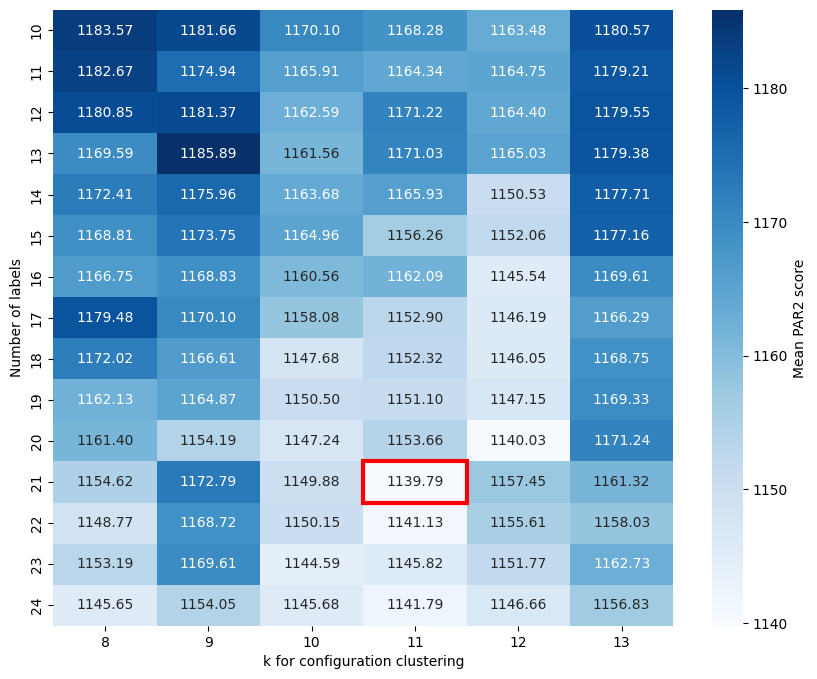

In [ ]:
import pickle
from helpers import *
import seaborn as sns
import numpy as np

results = []
for i in range(10,25):
    part= []
    for j in range(8,14):        
        with open('clusterbestlist/labels{}conf{}'.format(i, j), 'rb') as f:
            part.append(pickle.load(f))
    print(part)
    eval_data = [[entry['Eval'] for entry in result] for result in part]
    print(eval_data)
    means= [sum(e)/len(e) for e in eval_data]
    print(means)
    results.append(means)
#for i in range(10,25):
#    compareModels(results[i - 10], [i for i in range(8,14)])

import matplotlib.pyplot as plt
print(results)
# Convert results to a 2D array of averages for the heatmap
heatmap_data = results#np.array([np.mean(result, axis=0) for result in results])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=range(8, 14), yticklabels=range(10, 25), 
            cbar_kws={'label': 'Mean PAR2 score'})

# Find the indices of the minimum value
min_val = np.min(heatmap_data)
min_idx = np.unravel_index(np.argmin(heatmap_data), np.array(heatmap_data).shape)

# Highlight the lowest value with a red rectangle
plt.gca().add_patch(plt.Rectangle((min_idx[1], min_idx[0]), 1, 1, fill=False, edgecolor='red', lw=3))

plt.xlabel("k_config")
plt.ylabel("n_labels")
plt.show()

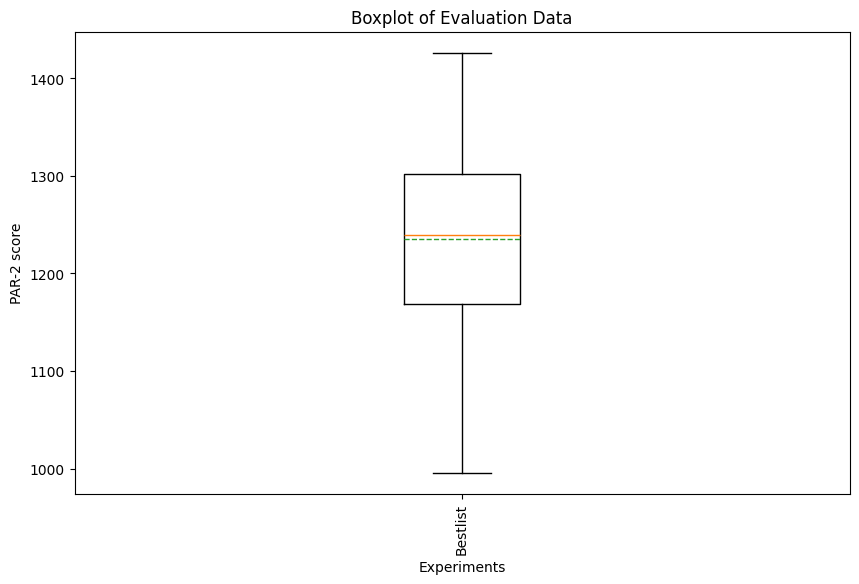

[1235.0042611116485]


In [7]:
from helpers import *
print(compareModels([results], ["Bestlist"]))

/home/raphael-zipperer/anaconda3/envs/SMAC/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/raphael-zipperer/anaconda3/envs/SMAC/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/raphael-zipperer/anaconda3/envs/SMAC/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/raphael-zipperer/anaconda3/envs/SMAC/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to

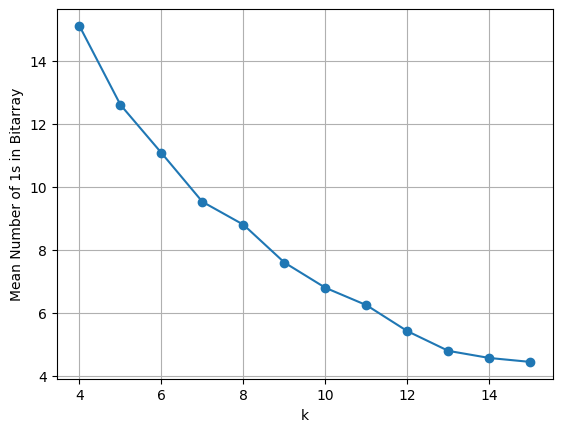

In [9]:
from sklearn.cluster import KMeans
from helpers import *
from gbd_core.api import GBD
from bitarray import bitarray
import numpy as np

from sklearn.decomposition import PCA

features = get_available_features()

def numBits(k=10, seed=0):
    with GBD([ '/home/raphael-zipperer/Uni/BA/database/base.db', '/home/raphael-zipperer/Uni/BA/database/meta.db' ]) as gbd:
        data = gbd.query('(track=main_2023 or track=main_2024) and minisat1m!=yes', resolve=features + ["family"])
    
        df = pd.read_csv("top40.csv")
    
        # Identify families with less than 5 entries
        family_counts = data['family'].value_counts()
        families_to_replace = family_counts[family_counts < 5].index
    
        # Replace the family label with "rest" for these families
        data['family'] = data['family'].apply(lambda x: 'rest' if x in families_to_replace else x)
    
        data_train, data_test = train_test_split(data, test_size=0.2, random_state=seed, stratify=data["family"])
        
        hashes_by_family = data_train.groupby("family")["hash"].apply(list).to_dict()
      
        famindeces = {}
        for fam, hashes in hashes_by_family.items():
            indeces = bestcluster(hashes, k).index.tolist()
        
            famindeces[fam] = indeces.copy()
        
        fam_bitarrays = {}
        for fam, indeces in famindeces.items():
            ba = bitarray(40)
            ba.setall(0)
            for index in indeces:
                ba[index] = 1
            fam_bitarrays[fam] = ba
        
        ones_count = {}
        for fam, ba in fam_bitarrays.items():
            count = ba.count(1)
            if count not in ones_count:
                ones_count[count] = 0
            ones_count[count] += 1
        return(ones_count)
#print(numBits())

import matplotlib.pyplot as plt


mean_bits = []
k_values = range(4, 16)

for k in k_values:
    ones_count = numBits(k=k)
    total_bits = sum(key * value for key, value in ones_count.items())
    total_families = sum(ones_count.values())
    mean_bits.append(total_bits / total_families)

plt.plot(k_values, mean_bits, marker='o')
plt.xlabel('k')
plt.ylabel('Mean Number of 1s in Bitarray')
plt.grid()
plt.show()

In [1]:
print(mean_bits)

NameError: name 'mean_bits' is not defined